In [6]:
import gym
import gym_examples
import numpy as np
from PIL import Image
from copy import deepcopy, copy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [7]:
env = gym.make('GridWorld-v0', render_mode='human')
env.reset()
env.render()

In [8]:
# assign step returns
observation, reward, terminated, truncated, info = env.step(3)
print(f'Observation: {observation}\nReward: {reward}\nTerminated: {terminated}\nTruncated: {truncated}\nInfo: {info}')
env.close()

Observation: {'agent': array([3, 1]), 'target': array([2, 4])}
Reward: 0
Terminated: False
Truncated: False
Info: {'distance': 4.0}


In [9]:
# Action space
print(f'Action space: {env.action_space}')

Action space: Discrete(4)


In [36]:
class Node():
    def __init__(self, state, action, action_list, visits=0, reward=0, parent=None):
        self.state = state
        self.action = action
        self.untried_actions = action_list
        self.action_list = action_list
        self.children = []
        self.visits = visits
        self.value = reward
        self.parent = parent
    
    def add_child(self, child):
        child = child
        self.children.append(child)
    
    def get_value(self):
        return self.value / self.visits if self.visits > 0 else 0
    
    def uct_value(self, parent_visits, c=1.4):
        # c is a constant that controls the degree of exploration

        # If the node or parent has not been visited, return infinity
        if self.visits == 0 or parent_visits == 0:
            return np.inf
        # Otherwise, return the standard UCT value
        else:
            return self.get_value() + c * np.sqrt(np.log(parent_visits) / self.visits)
    
    def selection(self):
        # check if the node has unexplored actions
        if len(self.untried_actions) > 0:
            return self
        else:
            uct_values = [child.uct_value(self.visits) for child in self.children]
            max_child = self.children[np.argmax(uct_values)]
            return max_child.selection()
    
    def expansion(self, env):
        # Randomly choose an unexpanded action
        expand_action = np.random.choice(self.untried_actions)
        obs, reward, terminated, truncated, info = env.step(expand_action)
        new_node = Node(obs, expand_action, self.action_list, reward=reward, visits=1)
        self.children.append(new_node)
        self.untried_actions = np.delete(self.untried_actions,np.where(self.untried_actions==expand_action))
        return new_node

    def rollout(self, env):
        terminated = False
        while not terminated:
            # Random rollout policy
            action = np.random.choice(env.action_space.n)
            obs, reward, terminated, truncated, info = env.step(action)
        return reward
    
    def backup(self, reward):
        self.visits += 1
        self.value += reward
        if self.parent:
            self.parent.backup(reward)

    def print_tree(self, depth=0, print_depth=0):
        if depth > print_depth:
            return
        if depth == 0:
            print(f'Root: {self.state}')
        else:
            print('   ' * depth,f' agent state: {self.state["agent"]}, visits: {self.visits}, reward: {self.value}')
        for child in self.children:
            child.print_tree(depth + 1, print_depth)

In [37]:
class MCTS():
    def __init__(self, env, state):
        self.env = env
        self.action_list = self._get_action_list()
        self.root = Node(state=state, action=None, action_list=self.action_list)
    
    def select_action(self):
        """
        Select the action with the highest visit count. 
        For a tie, select the action with the highest value.
        """
        best_action = None
        max_visits = -1
        best_value = -float('inf')
        children = self.root.children

        for child in children:
            if child.visits > max_visits or (child.visits == max_visits and child.value > best_value):
                best_action = child.action
                max_visits = child.visits
                best_value = child.value
        
        return best_action


    def mcts_find_action(self, num_iter, print_depth=0):
        for i in range(num_iter):
            self.run_iteration()
        # Choose the action with the highest visit count (+value tiebreaker) 
        action = self.select_action()
        
        if print_depth > 0:
            self.root.print_tree(0, print_depth)
        return action

    def run_iteration(self):
        '''Performs one iteration of the four steps of MCTS'''
        # Selection
        selected_leaf = self.root.selection()
        # Expansion
        expand_node = selected_leaf.expansion(self.env)
        # Simulation
        reward = expand_node.rollout(self.env)
        # Backup
        expand_node.backup(reward)

    def _get_action_list(self):
        # Assert that the action space is discrete
        assert isinstance(self.env.action_space, gym.spaces.Discrete)
        return np.arange(self.env.action_space.n)

In [38]:
def action_arrow(action):
    # Mapping the GridWorld actions to arrows
    # We have 4 actions, corresponding to "right", "up", "left", "down"
    return np.array(['→','↓','←','↑'])[action]
action_arrow(3)

'↑'

In [39]:
def render_rgb(rgb_array):
    display(Image.fromarray(rgb_array).resize((150,150)))

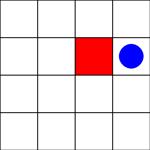

In [40]:
env = gym.make('GridWorld-v0', render_mode='rgb_array', size=4)
env.reset()
render_rgb(env.render())

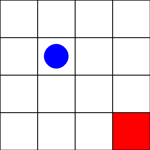

Root: {'agent': array([1, 1]), 'target': array([3, 3])}
     agent state: [1 0], visits: 2, reward: 1
     agent state: [3 3], visits: 2, reward: 2
     agent state: [2 3], visits: 2, reward: 1
     agent state: [3 3], visits: 2, reward: 2
Selected action: →
Obs: {'agent': array([2, 1]), 'target': array([3, 3])}


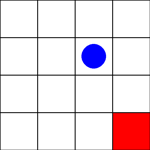

Root: {'agent': array([2, 1]), 'target': array([3, 3])}
     agent state: [2 2], visits: 2, reward: 1
     agent state: [2 3], visits: 2, reward: 1
     agent state: [3 3], visits: 2, reward: 2
     agent state: [3 2], visits: 2, reward: 1
Selected action: →
Obs: {'agent': array([3, 1]), 'target': array([3, 3])}


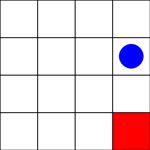

Root: {'agent': array([3, 1]), 'target': array([3, 3])}
     agent state: [2 1], visits: 2, reward: 1
     agent state: [3 3], visits: 2, reward: 2
     agent state: [3 3], visits: 2, reward: 2
     agent state: [3 2], visits: 2, reward: 1
Selected action: ↓
Obs: {'agent': array([3, 2]), 'target': array([3, 3])}


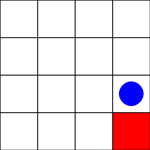

Root: {'agent': array([3, 2]), 'target': array([3, 3])}
     agent state: [3 1], visits: 2, reward: 1
     agent state: [3 3], visits: 2, reward: 2
     agent state: [3 3], visits: 2, reward: 2
     agent state: [2 3], visits: 2, reward: 1
Selected action: ↓
Obs: {'agent': array([3, 3]), 'target': array([3, 3])}


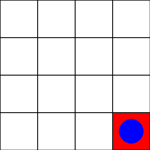

Terminated


In [41]:
# run MCTS on the environment
obs, info = env.reset()
render_rgb(env.render())

for i in range(7):
    # Copy the env for MCTS simulations
    mcts_env = deepcopy(env)
    mcts = MCTS(mcts_env, obs)
    action = mcts.mcts_find_action(25, print_depth=1)
    print(f'Selected action: {action_arrow(action)}')
    obs, reward, terminated, truncated, info = env.step(action)
    print(f'Obs: {obs}')
    render_rgb(env.render())
    if terminated:
        print('Terminated')
        break